# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

In [34]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [36]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

def show_pred(y_test, y_pred):
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    plt.xlabel("Predicted Sales Hl")
    plt.ylabel("True Sales Hl")

    plt.show()

In [37]:
DATASET_NAME = 'off-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [38]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays=workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [39]:
data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

if ('off-trade' in DATASET_NAME):
    lastYear = data.Year.max()
    data = data[(data.Year >= lastYear-3)]

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
16474,01015,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,1510.000000,9971.780620,1606.096830,2954.9000,5282.3000,14068.4000,1001.3000,1805.0000,3450.3998
16475,01016,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,197.619048,NaN,147.586571,451.2816,371.9232,558.9936,130.1256,159.1128,410.0324
16476,01022,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,NaN,283.333333,84.234569,64.6800,229.0200,313.9950,99.3300,72.4900,99.5995
16477,01027,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,NaN,NaN,7.246267,11.7216,20.9088,38.4120,6.6528,3.9600,6.6523
16478,01041,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,342.857143,678.853185,221.337900,261.0400,1491.2400,1327.8800,447.4800,410.4400,447.1999


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30896 entries, 16474 to 47369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          30896 non-null  object 
 1   ProductGroup      30896 non-null  object 
 2   PrimaryPack       30896 non-null  object 
 3   Country           30896 non-null  object 
 4   Year              30896 non-null  int64  
 5   Week              30896 non-null  int64  
 6   NumberWorkdays    30896 non-null  int64  
 7   AvgTemp           30896 non-null  float64
 8   PrevWeekAvgTemp   30896 non-null  float64
 9   AvgRain           30896 non-null  float64
 10  PrevWeekAvgRain   30896 non-null  float64
 11  AvgSun            30896 non-null  float64
 12  PrevWeekAvgSun    30896 non-null  float64
 13  IsLockdown        30896 non-null  bool   
 14  PdtHl             24466 non-null  float64
 15  PrevWeekPdtHl1    24145 non-null  float64
 16  BgtHl             25763 non-null  fl

In [41]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,30896.000000,30896.000000,30896.000000,30896.000000,30896.000000,30896.000000,30896.000000,30896.000000,30896.000000,24466.000000,24145.000000,25763.000000,30896.000000,29826.000000,29585.000000,25905.000000,22975.000000,28886.000000
mean,2019.228314,25.319556,4.776735,10.202486,10.160376,1.630474,1.613247,5.083675,5.062305,609.533519,604.730358,676.606361,627.543531,640.809632,640.710801,698.171907,740.006797,666.764856
std,0.976392,15.192791,0.505094,7.687036,7.691600,1.675338,1.650394,3.095009,3.112891,1502.558638,1498.103890,1406.378430,1509.962331,1524.844374,1531.692291,1608.972240,1682.785434,1533.553491
min,2018.000000,1.000000,2.000000,-8.278571,-8.278571,0.000000,0.000000,0.142857,0.142857,0.052800,0.052800,-28.562282,0.000000,0.000000,0.000000,0.000000,0.000000,0.062100
25%,2018.000000,12.000000,5.000000,3.276923,3.276923,0.400000,0.378571,2.214286,2.185714,28.588229,28.840015,47.179747,22.000000,24.792200,25.264800,38.544000,51.760000,33.009050
50%,2019.000000,24.000000,5.000000,9.964286,9.835714,1.062500,1.062500,5.007143,5.007143,125.026882,125.000000,186.724205,118.975200,124.464500,125.000000,165.168000,185.640000,146.700050
75%,2020.000000,39.000000,5.000000,16.792857,16.792857,2.364286,2.364286,7.264286,7.264286,484.069395,479.525817,676.917116,536.400000,555.930000,555.400000,641.520000,678.740000,612.820100
max,2021.000000,53.000000,5.000000,25.814286,25.814286,7.957143,7.957143,13.864286,13.864286,25234.055022,25234.055022,15540.040831,24281.500000,24281.500000,24281.500000,24281.500000,23150.600000,24865.201400


## Missing Values

In [42]:
data.isna().sum()

SkuShort            0   
ProductGroup        0   
PrimaryPack         0   
Country             0   
Year                0   
Week                0   
NumberWorkdays      0   
AvgTemp             0   
PrevWeekAvgTemp     0   
AvgRain             0   
PrevWeekAvgRain     0   
AvgSun              0   
PrevWeekAvgSun      0   
IsLockdown          0   
PdtHl               6430
PrevWeekPdtHl1      6751
BgtHl               5133
SalesHl             0   
PrevWeekSalesHl1    1070
PrevWeekSalesHl2    1311
PrevYearSalesHl1    4991
PrevYearSalesHl2    7921
OldPredSalesHl      2010
dtype: int64

## Data Visualizations

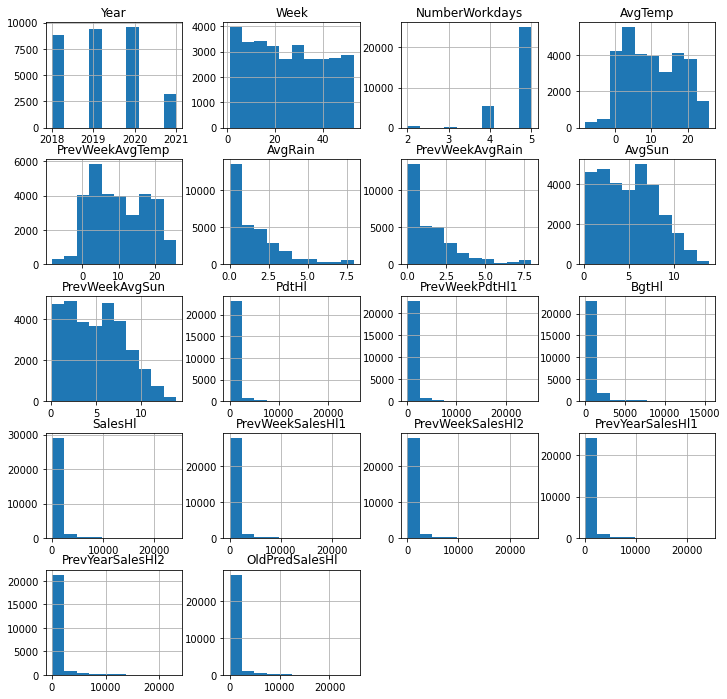

In [43]:
data.hist(figsize=[12,12])
plt.show()

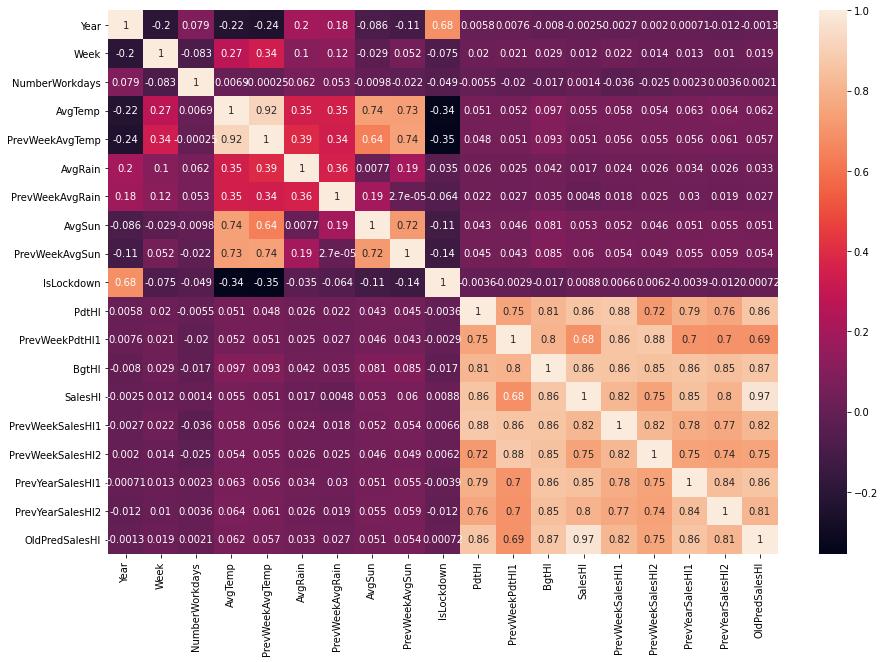

In [44]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

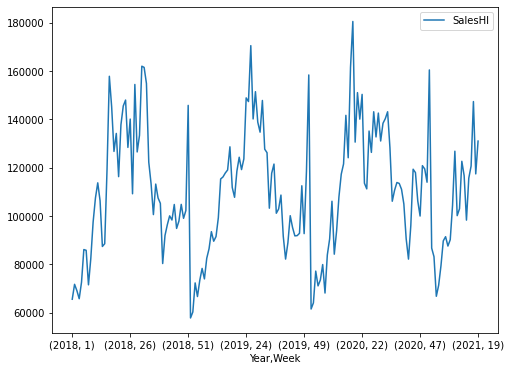

In [45]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

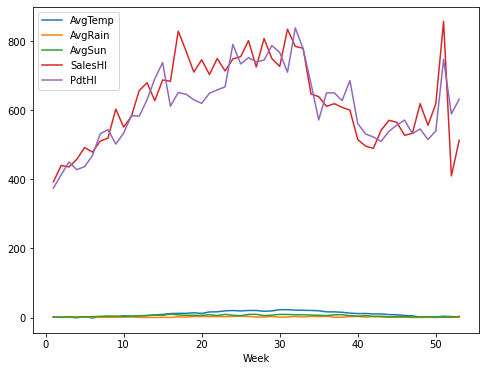

In [46]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

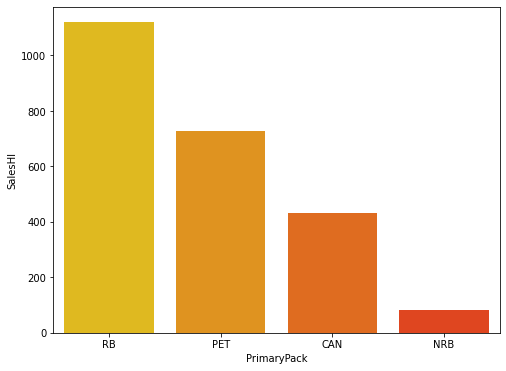

In [47]:
plt.figure(figsize=(8,6))
g_pps = data.groupby('PrimaryPack')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('PrimaryPack')
axis.set_ylabel('SalesHl')

plt.show()

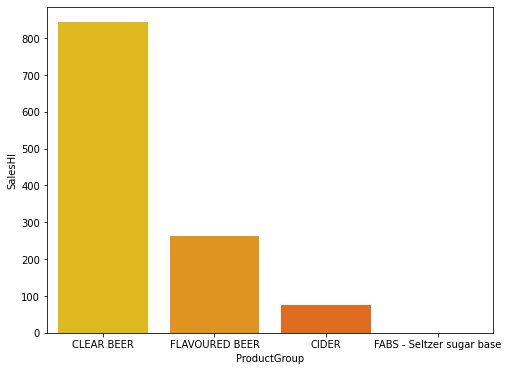

In [48]:
plt.figure(figsize=(8,6))
g_pgs = data.groupby('ProductGroup')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pgs.index, y=g_pgs, palette='autumn_r')
axis.set_xlabel('ProductGroup')
axis.set_ylabel('SalesHl')
plt.show()

In [49]:
# ordinals = ['Week','NumberWorkdays','AvgTemp','AvgRain','AvgSun','PdtHl','BgtHl','PrevWeekSalesHl1','PrevYearSalesHl1']

# fig, ax = plt.subplots(3, 5, figsize=(15, 10))
# fig.tight_layout()
# ax = iter(ax.flatten())
# for feat in ordinals:
#     dataplot = data[[feat, 'SalesHl']]
#     sns.boxplot(x=feat, y='SalesHl', data=dataplot, ax=next(ax))

In [50]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.973278
BgtHl,0.863480
PdtHl,0.858272
PrevYearSalesHl1,0.851639
PrevWeekSalesHl1,0.816763
PrevYearSalesHl2,0.803883
PrevWeekSalesHl2,0.746776
PrevWeekPdtHl1,0.682940
PrevWeekAvgSun,0.059528


## Skewness and Kurtesis

In [51]:
data.skew()

SkuShort            0.555835
Year                0.193431
Week                0.130756
NumberWorkdays     -2.718235
AvgTemp             0.080927
PrevWeekAvgTemp     0.097543
AvgRain             1.573170
PrevWeekAvgRain     1.610396
AvgSun              0.354366
PrevWeekAvgSun      0.365691
IsLockdown          1.272864
PdtHl               5.451801
PrevWeekPdtHl1      5.518879
BgtHl               4.523381
SalesHl             5.312801
PrevWeekSalesHl1    5.244335
PrevWeekSalesHl2    5.326497
PrevYearSalesHl1    5.169135
PrevYearSalesHl2    5.124643
OldPredSalesHl      5.083926
dtype: float64

In [52]:
data.kurt()

SkuShort           -0.753739 
Year               -1.048710 
Week               -1.215158 
NumberWorkdays      9.092669 
AvgTemp            -1.001133 
PrevWeekAvgTemp    -1.000859 
AvgRain             2.405550 
PrevWeekAvgRain     2.669565 
AvgSun             -0.671863 
PrevWeekAvgSun     -0.692877 
IsLockdown         -0.379842 
PdtHl               39.531579
PrevWeekPdtHl1      40.448859
BgtHl               25.448678
SalesHl             38.015014
PrevWeekSalesHl1    37.054270
PrevWeekSalesHl2    38.510068
PrevYearSalesHl1    35.081611
PrevYearSalesHl2    33.831348
OldPredSalesHl      34.082554
dtype: float64

## Create X, y

In [53]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'ProductGroup', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun' 'BgtHl',

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


In [54]:
# X['NextWeek'] = X['Week']+1
# X['PrevWeek'] = X['Week']-1

# X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

# X = X.drop(['NextWeek', 'PrevWeek', 'WeekPrev', 'WeekNext'], axis=1)
# X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
# X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
# X

## LabelEncoder

In [55]:
# create Temp
# bins = [-np.inf, -1, 1, 10, 15, 20, np.inf]
# names = ['mraz', 'kolem nuly', 'chladno', 'teplo', 'velmi teplo', 'horko']
# X['Temp'] = pd.cut(X['AvgTemp'], bins=bins, labels=names)
# X['PrevWeekTemp'] = pd.cut(X['PrevWeekAvgTemp'], bins=bins, labels=names)

# #create Rain
# bins = [0, 0.1, 2.5, 8, 40, np.inf]
# names = ['velmi slabá', 'slabá', 'mírná', 'silná', 'velmi silná']
# X['Rain'] = pd.cut(X['AvgRain'], bins=bins, labels=names)
# X['PrevWeekRain'] = pd.cut(X['PrevWeekAvgRain'], bins=bins, labels=names)

# #create Sun
# bins = [0, 2, 5, 8, np.inf]
# names = ['zatazeno', 'oblacno', 'polojasno', 'jasno']
# X['Sun'] = pd.cut(X['AvgSun'], bins=bins, labels=names)
# X['PrevWeekSun'] = pd.cut(X['PrevWeekAvgSun'], bins=bins, labels=names)

# X.Rain = LabelEncoder().fit_transform(X.Rain)
# X.Temp = LabelEncoder().fit_transform(X.Temp)
# X.Sun = LabelEncoder().fit_transform(X.Sun)
# X.PrevWeekTemp = LabelEncoder().fit_transform(X.PrevWeekTemp)
# X.PrevWeekRain = LabelEncoder().fit_transform(X.PrevWeekRain)
# X.PrevWeekSun = LabelEncoder().fit_transform(X.PrevWeekSun)

# X = X.drop(['AvgTemp', 'AvgRain', 'AvgSun', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'], axis=1)

#round weather
# X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
# X.AvgRain = X.AvgRain.round(1)#.astype('int64')
# X.AvgSun = X.AvgSun.round(1)#.astype('int64')

In [56]:
Country_mapping = {"CZ": 1, "SK": 2}
PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

el = LabelEncoder()
X.SkuShort = el.fit_transform(X.SkuShort)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
16474,0,3,1,2018,1,4,5.1125,1.0625,0.925,False,1510.000000,9971.780620,1606.096830,5282.3000,14068.4000,1001.3000,1805.0000
16475,1,3,1,2018,1,4,5.1125,1.0625,0.925,False,197.619048,NaN,147.586571,371.9232,558.9936,130.1256,159.1128
16476,2,3,1,2018,1,4,5.1125,1.0625,0.925,False,NaN,283.333333,84.234569,229.0200,313.9950,99.3300,72.4900
16477,4,3,1,2018,1,4,5.1125,1.0625,0.925,False,NaN,NaN,7.246267,20.9088,38.4120,6.6528,3.9600
16478,6,3,1,2018,1,4,5.1125,1.0625,0.925,False,342.857143,678.853185,221.337900,1491.2400,1327.8800,447.4800,410.4400


## Imputer

In [57]:
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [58]:
si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)

si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X = pd.DataFrame(si.transform(X), columns=X.columns)

## Adding a New Feature

In [59]:
#X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#X.Date = X.Date.map(datetime.datetime.toordinal)

#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')

# X['SalesPerPdt'] = X['PrevWeekSalesHl1'].divide(X['PrevWeekPdtHl1'], fill_value=0) #dataset['PrevWeekSalesHl1'] / dataset['PrevWeekPdtHl1']
# X['SalesPerPdt'] = X['SalesPerPdt'].replace([np.inf, -np.inf, np.nan], 0)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,3.0,1.0,2018.0,1.0,4.0,5.1125,1.0625,0.925,0.0,1510.000000,9971.780620,1606.096830,5282.3000,14068.4000,1001.3000,1805.0000,9675.4,1403.2,5539.2
1,1.0,3.0,1.0,2018.0,1.0,4.0,5.1125,1.0625,0.925,0.0,197.619048,0.000000,147.586571,371.9232,558.9936,130.1256,159.1128,465.5,144.6,305.0
2,2.0,3.0,1.0,2018.0,1.0,4.0,5.1125,1.0625,0.925,0.0,0.000000,283.333333,84.234569,229.0200,313.9950,99.3300,72.4900,271.5,85.9,178.7
3,4.0,3.0,1.0,2018.0,1.0,4.0,5.1125,1.0625,0.925,0.0,0.000000,0.000000,7.246267,20.9088,38.4120,6.6528,3.9600,29.7,5.3,17.5
4,6.0,3.0,1.0,2018.0,1.0,4.0,5.1125,1.0625,0.925,0.0,342.857143,678.853185,221.337900,1491.2400,1327.8800,447.4800,410.4400,1409.6,429.0,919.3


In [60]:
X.tail()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
30891,232.0,1.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,0.000000,0.000000,19.560704,1.4256,7.9200,1.742400,740.006797,4.7,370.9,187.8
30892,248.0,4.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,65.595430,26.024002,676.606361,149.0544,134.1648,698.171907,740.006797,141.6,719.1,430.3
30893,250.0,4.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,59.595430,21.595430,676.606361,114.8400,108.9792,698.171907,740.006797,111.9,719.1,415.5
30894,254.0,1.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,77.928504,197.214218,164.929034,126.6000,267.7200,142.560000,71.880000,197.2,107.2,152.2
30895,260.0,1.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,55.279089,138.136232,83.367762,80.5200,197.5200,56.160000,47.880000,139.0,52.0,95.5


## Split train, test

In [61]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)

#X = X.drop(['Year'], axis=1)
# X['Year'] = (X['Year']-1900).astype(int)
 
X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

X_test.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
29172,0.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,7361.289056,5214.431913,6846.230237,8267.8000,4305.700000,9069.800000,7285.300000,6286.8,8177.6,7232.2
29173,1.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,302.937182,331.508610,413.645388,109.9296,230.630400,175.111200,157.132800,170.3,166.1,168.2
29174,4.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,0.000000,0.000000,7.049176,9.8208,10.454400,5.940000,17.424000,10.1,11.7,10.9
29175,6.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,0.000000,14.285714,450.519687,519.0800,364.840000,168.520000,266.840000,442.0,217.7,329.8
29176,7.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,252.000000,0.000000,676.606361,864.0000,640.710801,698.171907,740.006797,752.4,719.1,735.7


## Scaler

In [62]:
#scaler = MinMaxScaler() #0.8361
#scaler = MaxAbsScaler() #0.8335
scaler = StandardScaler() #0.8381
#scaler = RobustScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# y_train = np.log1p(y_train)
# X_test = np.log1p(X_test)

## Regressor

In [63]:
rf_params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200, 250, 300]
}

xgb_params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.09, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    'colsample_bytree': [0.4, 0.5 , 0.7],
    'n_estimators': [100, 200, 300, 400, 500]
}

model = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)

param_grid = dict(depth=[6,8,10], learning_rate=[0.01, 0.05, 0.1], iterations=[1000, 1500, 2000])
clf = GridSearchCV(model, param_grid, n_jobs=4) #, random_state=0
search = clf.fit(X_train, y_train.values.ravel())
#print(search.cv_results_)
print(search.best_score_)
print(search.best_params_)


# {'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.10000000149011612, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 64}

In [ ]:
sdfasdfa

In [298]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
# model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
# model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
# model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049




# hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
# mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
#rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, bootstrap=True, criterion='mse', oob_score=True, n_jobs=4)


# xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)
# # lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)
# model = LGBMRegressor() #0.8059

# model = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)#0.8467


# def baseline_model():
#     model = Sequential()
#     model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model


# model = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)


# # Train the model using the training sets
# model.fit(X_train, y_train.values.ravel())

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# # # The mean squared error
# # print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

# print(DATASET_NAME)
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# # #Best possible score is 1.0, lower values are worse.
# # print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

# #max_error metric calculates the maximum residual error.
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# # #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
# print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))



#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5829 (0.6246), 0.8377 (0.8027)
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8686 (0.8584), 0.8561 (0.8597)
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418

 #0.8929

In [299]:
#asdfasd

### HistGradientBoostingRegressor 

In [300]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

### MLPRegressor

In [301]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [302]:
rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, max_depth=None, max_features=None, bootstrap=True, criterion='mse', oob_score=True, n_jobs=2)

### XGBRegressor

In [303]:
xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)

### CatBoostRegressor

In [304]:
cbModel = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)

In [305]:
lModel = linear_model.Lasso(random_state=0, selection='random')

In [306]:
lgbmModel = LGBMRegressor(n_jobs=3)

In [307]:
ardModel = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False)

In [308]:
brModel = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

In [309]:
gbrModel = ensemble.GradientBoostingRegressor()

In [310]:
knModel = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1)

In [311]:
lsvrModel = svm.LinearSVR()

In [312]:
lrModel = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)

### Use models

In [313]:
# LGBMRegressor
# CatBoostRegressor
# HistGradientBoostingRegressor
# GradientBoostingRegressor

regression_models = [lgbmModel, cbModel, hgbModel, rfModel, xgbModel]
regression_models

[LGBMRegressor(n_jobs=3),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=350, max_leaf_nodes=70, random_state=0),
 RandomForestRegressor(max_features=None, n_estimators=1000, n_jobs=2,
                       oob_score=True, random_state=0),
 XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method='approx', validate_parameters=None,
              verbosity=None)]

In [314]:
estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train.values.ravel())
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, me, rmse, mae]

    estimators.append((model_name, reg_model))

    show_pred(y_test, y_pred)

In [315]:
result_models["Weights"] = result_models['Score'].map(lambda x: round(x, 2))
result_models.sort_values(by=['Score'], ascending=False)


#off-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 6	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 0	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 9	GradientBoostingRegressor	0.843769	391493.638902	391493.638902	264.494670	0.84
# 4	MLPRegressor	0.839527	402124.902408	402124.902408	278.039271	0.84
# 12	LinearRegression	0.832977	418538.501574	418538.501574	308.129606	0.83
# 5	Lasso	0.832871	418803.072085	418803.072085	307.357371	0.83
# 7	ARDRegression	0.832818	418936.806781	418936.806781	307.672709	0.83
# 8	BayesianRidge	0.832793	418999.803428	418999.803428	308.173667	0.83
# 11	LinearSVR	0.829922	426193.915922	426193.915922	270.611320	0.83
# 10	KNeighborsRegressor	0.805067	488476.376995	488476.376995	305.001409	0.81
# 1	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8639

# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 3	GradientBoostingRegressor	0.844420	389862.886930	389862.886930	264.334610	0.84
# 0.8668


# 	Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 4	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8658


#on-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 6	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 0	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 9	GradientBoostingRegressor	0.842605	67122.924254	67122.924254	106.539311	0.84
# 10	KNeighborsRegressor	0.815448	78704.180046	78704.180046	135.666990	0.82
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 12	LinearRegression	0.811924	80207.259648	80207.259648	170.711040	0.81
# 5	Lasso	0.810957	80619.289766	80619.289766	169.174454	0.81
# 7	ARDRegression	0.810064	81000.421378	81000.421378	170.797118	0.81
# 8	BayesianRidge	0.808762	81555.376370	81555.376370	171.263265	0.81
# 11	LinearSVR	0.791987	88709.547162	88709.547162	123.906669	0.79
# 4	MLPRegressor	0.599296	170884.695195	170884.695195	177.887054	0.60
# 0.8598


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	GradientBoostingRegressor	0.834394	70624.630360	70624.630360	107.111241	0.83
# 0.8747


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 0.8717


# 	Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 4	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
#0.8798

,Model,Score,MSE,RMSE,MAE,Weights
3,RandomForestRegressor,0.866791,333804.805779,333804.805779,244.611777,0.87
0,LGBMRegressor,0.864042,340693.041703,340693.041703,254.249443,0.86
2,HistGradientBoostingRegressor,0.861159,347916.449315,347916.449315,254.998749,0.86
1,CatBoostRegressor,0.849278,377688.576685,377688.576685,261.573181,0.85
4,XGBRegressor,0.772603,569827.345052,569827.345052,297.754979,0.77


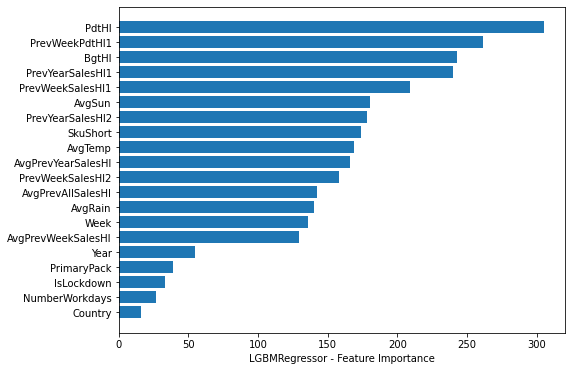

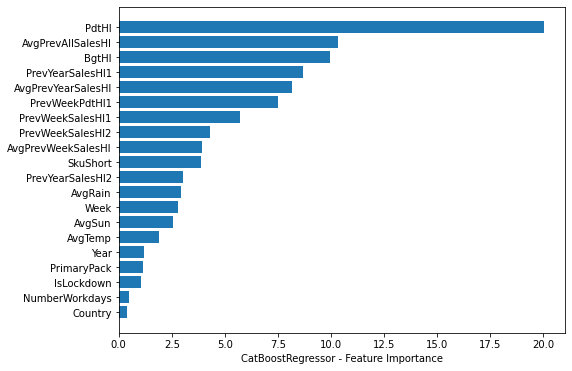

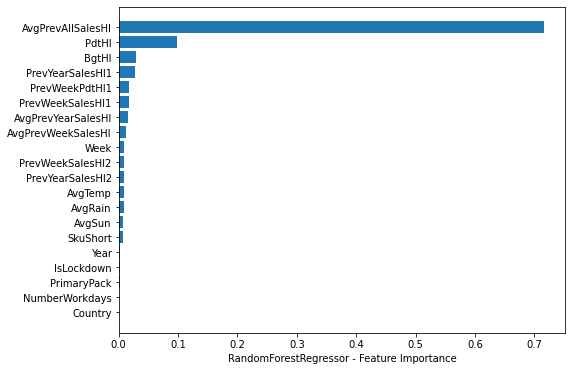

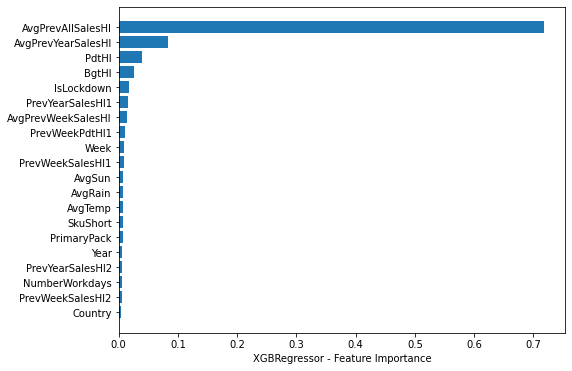

In [316]:
for key, model in estimators:
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(8,6))
        sorted_idx = model.feature_importances_.argsort()
        plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
        plt.xlabel(f"{key} - Feature Importance")
        plt.show()

### VotingRegressor

In [317]:
model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))



off-trade
Coefficient of determination: 0.8658
Maximum residual error: 5370.0000
Mean absolute percentage error regression loss: 18043133773925764.0000
Old Coefficient of determination: 0.9544
Old Maximum residual error: 4029.0000
Mean absolute percentage error regression loss: 334373986254886.6875


## Model analysis

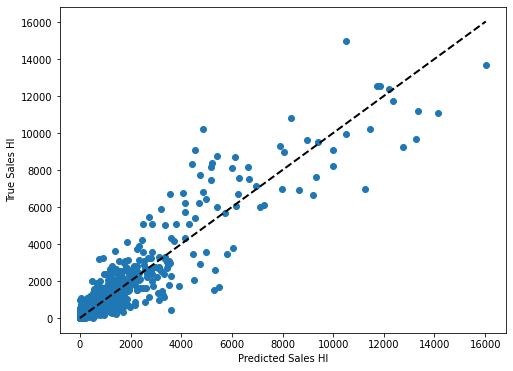

In [318]:
# plt.figure(figsize=(8,6))
# plt.scatter(y_test, y_pred)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# plt.xlabel("Predicted Sales Hl")
# plt.ylabel("True Sales Hl")

# plt.show()

show_pred(y_test, y_pred)

In [319]:
plt.figure(figsize=(8,6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

AttributeError: 'VotingRegressor' object has no attribute 'feature_importances_'

In [430]:
result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10    99.2%          76.2%          -23.0%           
     11    92.7%          98.3%          5.7%             
     12    93.5%          96.7%          3.2%             
     13    57.3%          49.3%          -8.0%            
     14    64.8%          93.6%          28.8%            
     15    86.0%          90.3%          4.2%             
     16    99.3%          75.8%          -23.5%           
     17    94.1%          66.3%          -27.8%           
     18    81.8%          87.9%          6.1%             
     19    73.4%          74.1%          0.7%             
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021  82.6%          82.1%          -0.5%            


In [980]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# X_labels = X.columns.tolist()
# forest_importances = pd.Series(result.importances_mean, index=X_labels)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

exception calling callback for <Future at 0x29f4d15fc10 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\K\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Program Files\Python39\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "sklearn\tree\_tree.pyx", line 671, in sklearn.tree._tree.Tree.__setstate__
  File "sklearn\tree\_tree.pyx", line 705, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 1858024 bytes
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\K\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\_b

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [345]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()
X_labels = X.columns.tolist()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=X_labels)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

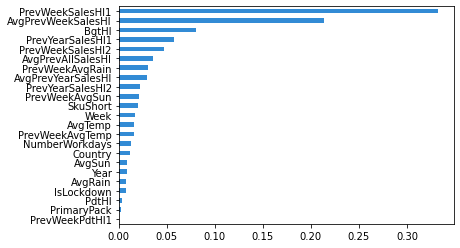

In [346]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [94]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [95]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [96]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [97]:
# shap.plots.force(shap_values[0])

In [98]:
# shap.plots.force(shap_values)

In [99]:
# shap.plots.scatter(shap_values, color=shap_values)

In [100]:
# shap.plots.bar(shap_values)

In [101]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [102]:
result = X_test_raw.copy(deep=True)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [103]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [104]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363